## Q leaning with value function aproximation

In [32]:
import numpy as np
import gym
from gym import Env
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from torch import Tensor
import torch.nn.functional as F
from torch.optim import Optimizer, SGD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.kernel_approximation import RBFSampler

# Logging in a good format
! pip install tensorboard
from torch.utils.tensorboard import SummaryWriter

from typing import Callable
import itertools


### The sate of the environment 
- x: the car position
- v: the linear speed of the car
- theta: the angle of the pole
- omega: the angular velocilty of the pole

In [33]:
env = gym.make('CartPole-v1')
env.reset()

# Min and max values for each dimension
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [34]:
observation_samples = np.array([env.observation_space.sample() for x in range(1000)]) 

# too many states generates overflow in dist paramas computation

mean_states = observation_samples.mean(axis=0)
std_states = observation_samples.std(axis=0)

def normalize_state(state: Tensor) -> Tensor:
    return (state - torch.from_numpy(mean_states)) / torch.from_numpy(std_states)
    

C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\Popescu Andrei\anaconda3\envs\ml\lib\site-packages\numpy\core\_methods.py:212: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)


In [193]:
class Aproximator(nn.Module):
    def __init__(self, input_size: int, output_size: int) -> None:
        super(Aproximator, self).__init__()
        
        # Perform a small linear transformation to make sure that we have some information gain
        self.net = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=output_size * 2, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=output_size * 2, out_features=output_size, bias=True),
            nn.ReLU()
        )
        
    def encoder(self, x: Tensor) -> Tensor:
        # The state featurizer
        pass
        
    
    def forward(self, x: np.ndarray) -> Tensor:
        x = torch.from_numpy(x)
        return self.net(x)

## Epsilon greedy policy function

In [194]:
def epsilon_greedy_policy(aproximator: Aproximator, eps: float, number_of_actions: int) -> Callable:
    
    def policy_fn(observation: np.ndarray) -> np.ndarray:
        A = np.ones(number_of_actions, dtype=float) * eps / number_of_actions
        q_values = aproximator(observation)
        best_action = np.argmax(q_values.detach().numpy())
        A[best_action] += (1.0 - eps)
        return A
    
    return policy_fn

## Q learning 

In [195]:
def q_learning( env: Env, 
                aproximator: Aproximator,
                optimizer: Optimizer,
                num_epochs: int, 
                gamma: float = 0.9, # default discount factor 
                eps: float = 0.1,
                eps_decay_factor: float = 0.9 # for eps decay
              ):
    
    # Create a loss function for the aproximator
    loss_fn = torch.nn.MSELoss()
    losses = []
    for epoch in range(num_epochs):
        
        policy = epsilon_greedy_policy(
            aproximator=aproximator, 
            eps=eps * eps_decay_factor**epoch, 
            number_of_actions=env.action_space.n
        )
        
        state = env.reset()
        
        for t in itertools.count():
            
            action_probabilities = policy(state)
            action = np.random.choice(np.arange(len(action_probabilities)), p=action_probabilities)
            
            next_state, reward, end, _ = env.step(action)
            
            q_values_next = aproximator(next_state)
            td_target = reward + gamma * torch.max(q_values_next)
            
            loss = F.mse_loss(td_target, torch.max(q_values_next))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
               
                
            losses.append(loss.detach().numpy().item())
            
            if epoch % 1000 == 0:
                print("\rStep {} @ Episode {}/{} ({})".format(t, epoch + 1, num_epochs, reward))
                
            if end:
                break
                
            state = next_state
    return losses

In [196]:
aproximator = Aproximator(input_size=4, output_size=2)

In [197]:
optimizer = SGD(params=aproximator.parameters(), lr=1e-3)

Step 0 @ Episode 1/1000 (1.0)
Step 1 @ Episode 1/1000 (1.0)
Step 2 @ Episode 1/1000 (1.0)
Step 3 @ Episode 1/1000 (1.0)
Step 4 @ Episode 1/1000 (1.0)
Step 5 @ Episode 1/1000 (1.0)
Step 6 @ Episode 1/1000 (1.0)
Step 7 @ Episode 1/1000 (1.0)
Step 8 @ Episode 1/1000 (1.0)


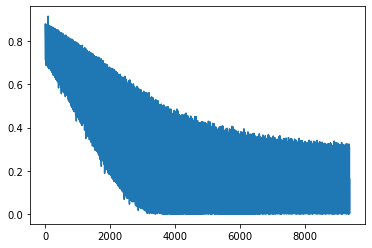

In [198]:
losses = q_learning(aproximator=aproximator, optimizer=optimizer, env=env, num_epochs=1000)
plt.plot([i for i in range(len(losses))], losses)

- [ ] plot episodes reward over time
- [ ] resolve training problems and featurizer function (embedding for state)
- [ ] resolve small renderer 

True

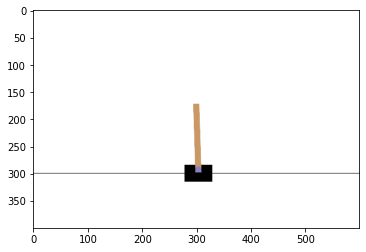

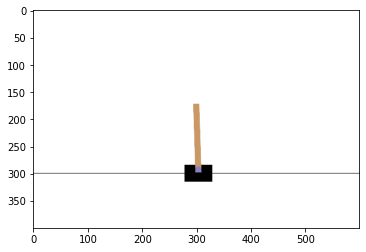

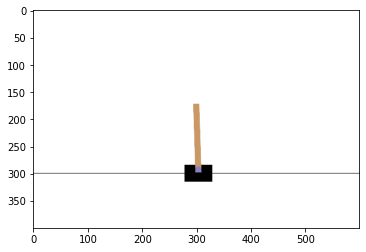

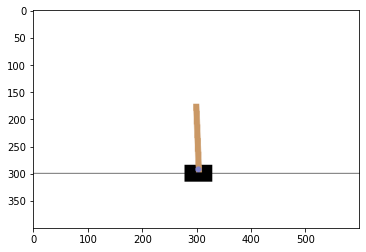

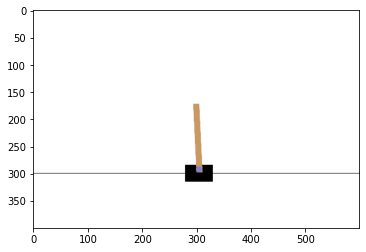

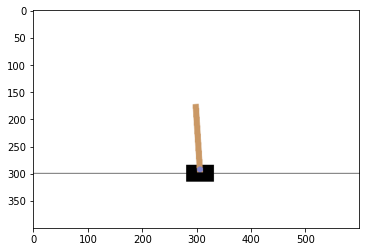

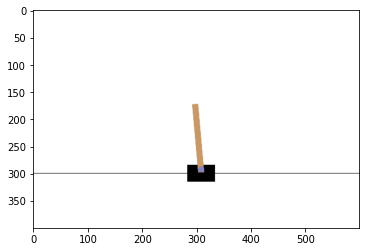

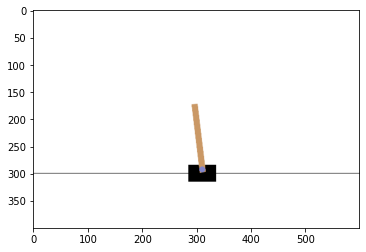

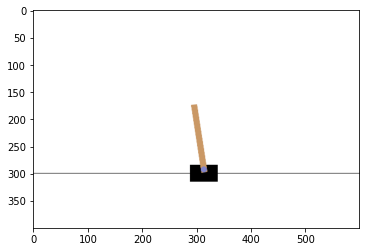

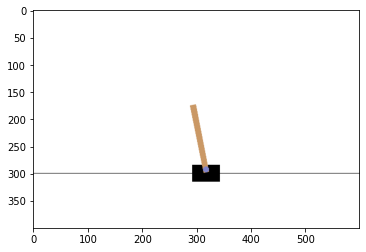

In [199]:
state = env.reset()
plt.figure()
plt.imshow(env.render(mode='rgb_array'))
while(True):
    q_values = aproximator(state).detach().numpy()
    best_action = np.argmax(q_values)
    plt.figure()
    plt.imshow(env.render(mode='rgb_array'))
    
    next_state, reward, end, _ = env.step(best_action)
    if end:
        break
        
    state = next_state
    env.render()
env.render()